In [11]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [24]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import warnings

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore') 

from src.SavingFeedback import SavingFeedback
from src import crs, PublicPredictor
from src.dbc import utils, TimeDivisionKMeans
import src.utils as ut

In [25]:
# 1. load_excel
data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)

# 3. data init
_month = 1

month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)

month_df.columns = ['name', 'usage (kWh)']

PUBLIC_PERCENTAGE = 30
APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)

calc = crs.models.ManagementOffice(
        month=_month,
        households=month_df,
        APT=APT,
        contract="단일계약"
    )
apt = calc.apart

In [26]:
households = calc.households

households[month_df[month_df['name'] == '아파트1-103-1602'].index[0]].elec_bill

43420

In [27]:
fee = calc.fee
public_bill = calc.public_bill
public_bill

2640560

In [28]:
_public_bill = public_bill / len(month_df)
_public_bill

24449.62962962963

# 데이터 준비 및 전처리

In [308]:
sv = SavingFeedback(xlsx)

sv.m_60.head()

,아파트1-104-1206,아파트1-104-303,아파트1-104-1307,아파트1-104-1208,아파트1-104-408,아파트1-104-203,아파트1-103-1402,아파트1-103-402,아파트1-103-1201,아파트1-103-801,...,아파트1-102-901,아파트1-103-1905,아파트1-103-503,아파트1-103-1504,아파트1-103-606,아파트1-103-903,아파트1-103-1106,아파트1-103-705,아파트1-103-1505,아파트1-103-406
2018-05-01 00:00:00,0.341,0.121,0.245,0.009,0.085,0.154,0.161,0.311,0.358,0.177,...,0.372,0.181,0.322,0.374,0.571,0.453,0.161,0.127,0.259,0.364
2018-05-01 01:00:00,0.337,0.186,0.285,0.01,0.071,0.127,0.179,0.225,0.206,0.178,...,0.245,0.238,0.292,0.382,0.327,0.352,0.172,0.133,0.234,0.286
2018-05-01 02:00:00,0.324,0.214,0.487,0.009,0.061,0.139,0.182,0.221,0.15,0.152,...,0.245,0.25,0.287,0.32,0.359,0.366,0.242,0.219,0.197,0.368
2018-05-01 03:00:00,0.319,0.25,0.3,0.009,0.067,0.132,0.172,0.274,0.142,0.205,...,0.177,0.223,0.329,0.17,0.322,0.267,0.269,0.164,0.229,0.414
2018-05-01 04:00:00,0.235,0.199,0.107,0.009,0.047,0.131,0.153,0.255,0.139,0.169,...,0.129,0.171,0.301,0.168,0.351,0.255,0.17,0.132,0.198,0.318


In [309]:
sv.select_month(1)

sv.datas.head()

,아파트1-104-1206,아파트1-104-303,아파트1-104-1307,아파트1-104-1208,아파트1-104-408,아파트1-104-203,아파트1-103-1402,아파트1-103-402,아파트1-103-1201,아파트1-103-801,...,아파트1-102-901,아파트1-103-1905,아파트1-103-503,아파트1-103-1504,아파트1-103-606,아파트1-103-903,아파트1-103-1106,아파트1-103-705,아파트1-103-1505,아파트1-103-406
2019-01-01 00:00:00,0.033,0,0.034,0.037,0.062,0.322,0.24,0.295,0.373,0.243,...,0.534,0.188,0.4,0.318,0.42,0.626,0.484,0.289,0.305,0.652
2019-01-01 01:00:00,0.048,0,0.033,0.037,0.063,0.185,0.257,0.397,0.257,0.228,...,0.396,0.434,0.355,0.25,0.465,0.409,0.459,0.336,0.332,0.557
2019-01-01 02:00:00,0.032,0,0.039,0.036,0.062,0.175,0.384,0.353,0.123,0.141,...,0.194,0.337,0.379,0.274,0.326,0.307,0.405,0.382,0.311,0.491
2019-01-01 03:00:00,0.033,0,0.039,0.037,0.062,0.167,0.276,0.488,0.142,0.159,...,0.286,0.263,0.375,0.264,0.336,0.345,0.298,0.291,0.261,0.511
2019-01-01 04:00:00,0.032,0.001,0.033,0.037,0.063,0.197,0.266,0.278,0.19,0.227,...,0.275,0.245,0.31,0.423,0.36,0.364,0.212,0.347,0.294,0.507


# KMeans Clustering

ECV : 47 %


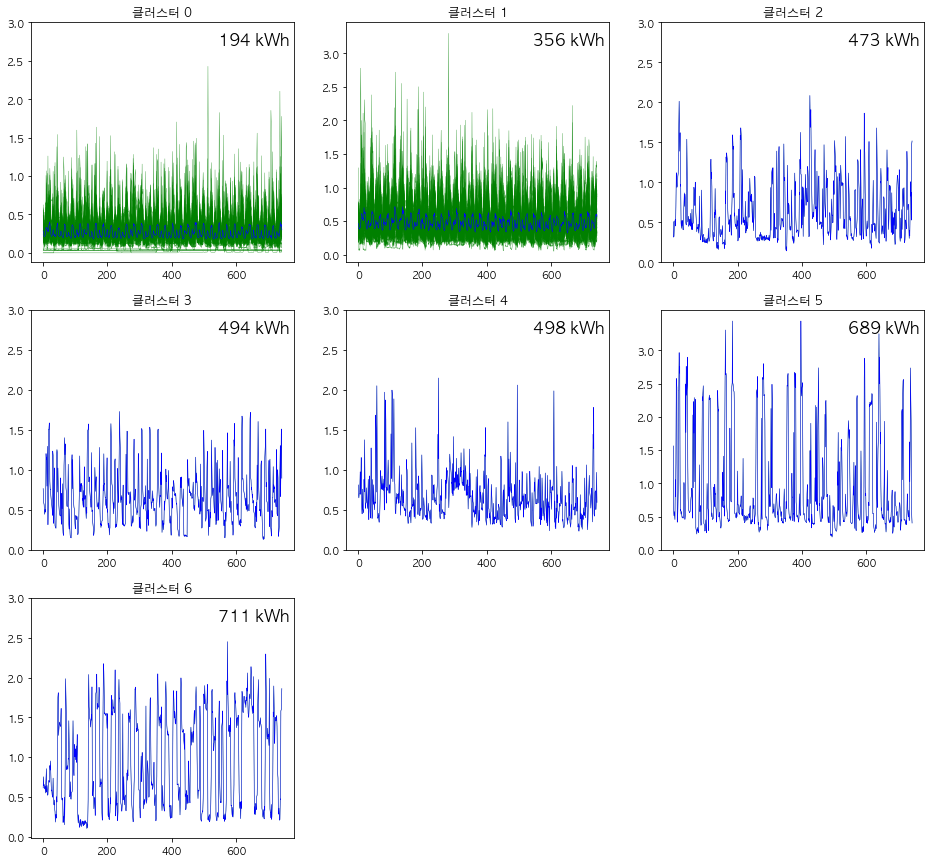

In [310]:
sv.kmeans_run()

sv.kmeans.draw_plot()

In [311]:
sv.group.head()

,name,usage (kWh),label
0,아파트1-104-1206,99,0
1,아파트1-104-303,10,0
2,아파트1-104-1307,23,0
3,아파트1-104-1208,40,0
4,아파트1-104-408,39,0


# anomaly Check

In [312]:
anomaly = sv.check_anomaly()

anomaly.head()

""


# adjust anomaly

In [313]:
sv.adjust_anomaly()
anomaly = sv.check_anomaly()

anomaly.head()

""


In [314]:
print("순차 조정 확인", np.unique(sv.group['label'].values))

순차 조정 확인 [0 1 2 3 4 5 6]


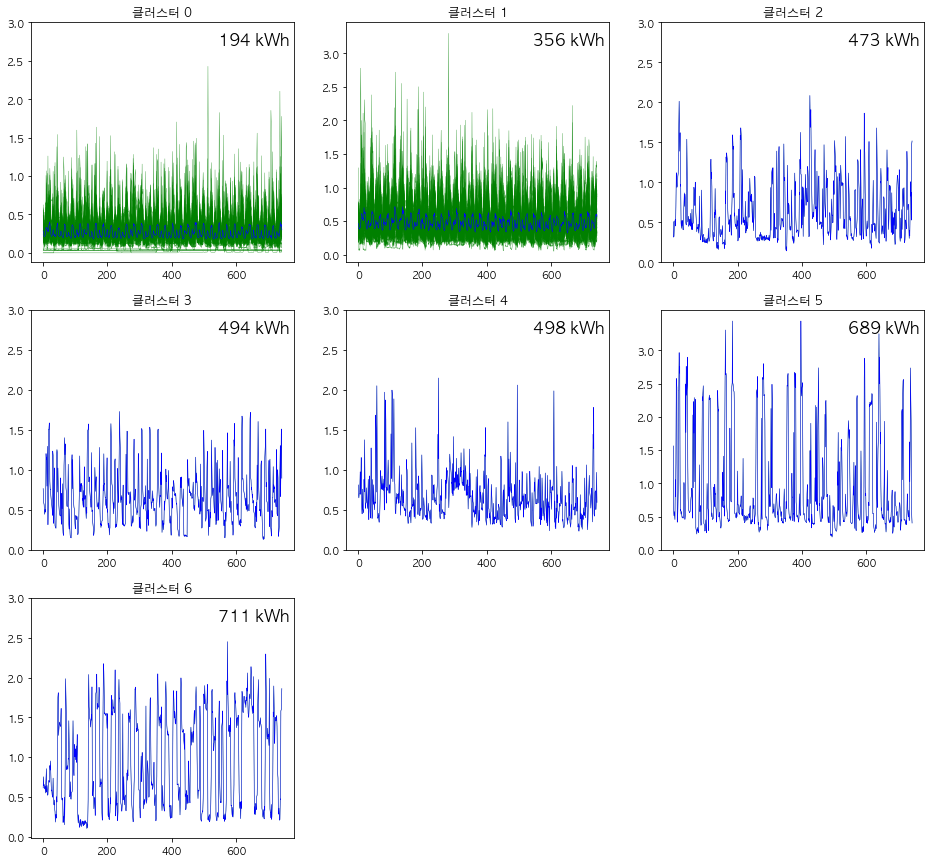

In [315]:
sv.kmeans.draw_plot()

# 시간대 Grouping

In [481]:
time_size = 4
sv.time_based_grouping(time_size)

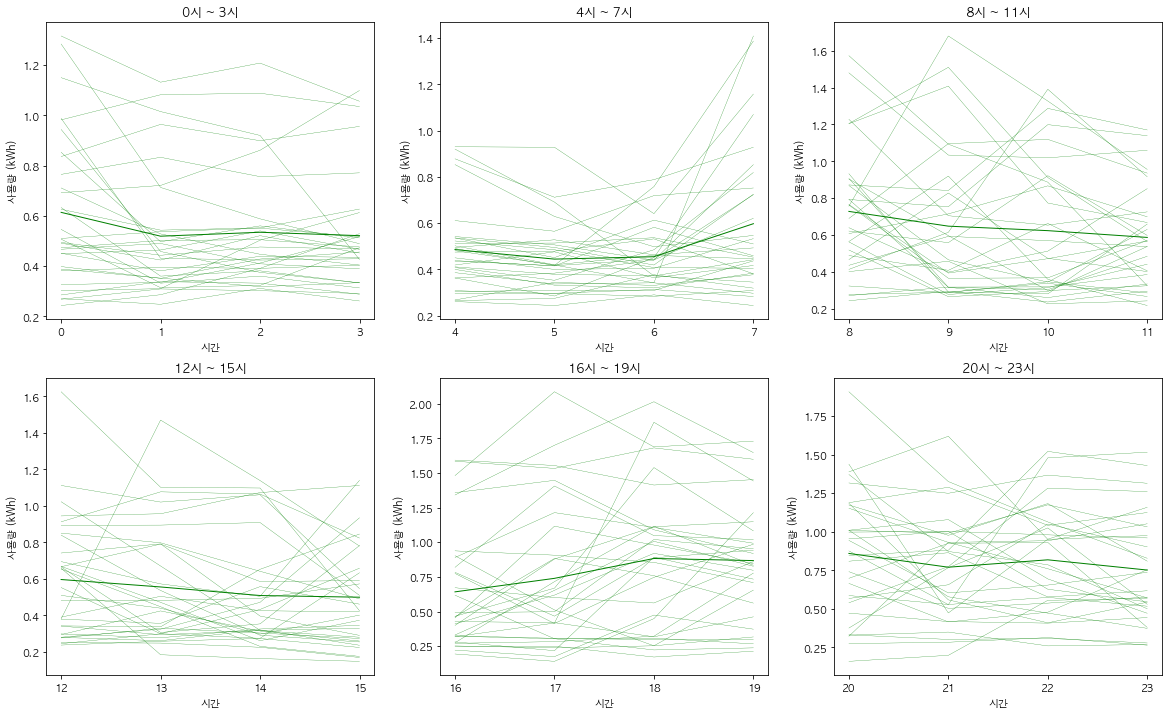

In [482]:
times = [(start_time, start_time + (time_size-1))
             for start_time in range(0, 24, time_size)]
plt.figure(figsize=(20, 12))

for idx, group in enumerate(sv.clusters_[2][0]):
    mean_group = group.mean(axis=0)
    start_time, end_time = times[idx]
    ax = plt.subplot(2, 3, idx+1)
    
    ax.plot(range(start_time,end_time + 1),group.T, color='g', linewidth=0.25)
    ax.plot(range(start_time,end_time + 1),mean_group, color='g', linewidth=1)
    ax.set_title("{}시 ~ {}시".format(start_time, end_time))
    plt.xticks(range(start_time,end_time + 1))
    plt.xlabel("시간")
    plt.ylabel("사용량 (kWh)")

plt.show()

# 요일별 Grouping

In [362]:
sv.day_based_grouping()

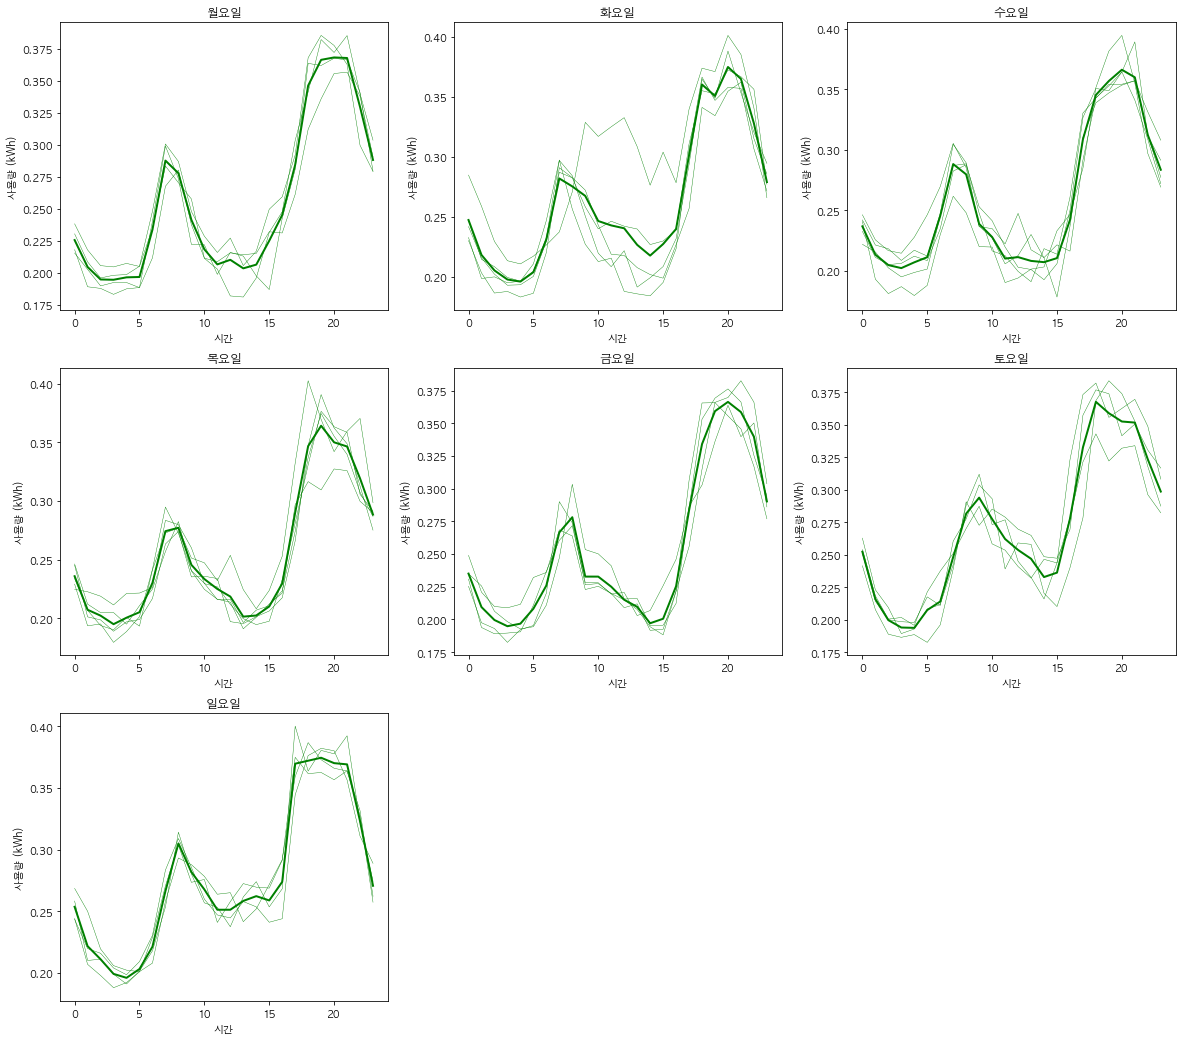

In [363]:
plt.figure(figsize=(20, 18))

days = ['월', '화', '수', '목', '금', '토', '일']
for idx, group in enumerate(sv.clusters_[0][0]):
    mean_group = group.mean(axis=0)
    day = days[idx]
    
    ax = plt.subplot(3, 3, idx+1)
    
    ax.plot(group.T, color='g', linewidth=0.4)
    ax.plot(mean_group, color='g', linewidth=2)
    ax.set_title("{}요일".format(day))
    plt.xlabel("시간")
    plt.ylabel("사용량 (kWh)")

plt.show()

# 전기절약 피드백 예시

In [367]:
sv.group

,name,usage (kWh),label
0,아파트1-104-1206,99,0
1,아파트1-104-303,10,0
2,아파트1-104-1307,23,0
3,아파트1-104-1208,40,0
4,아파트1-104-408,39,0
...,...,...,...
103,아파트1-103-903,273,0
104,아파트1-103-1106,255,0
105,아파트1-103-705,228,0
106,아파트1-103-1505,384,1


In [397]:
def feedback(name):
    target_house = sv.group[sv.group['name'] == name]
    print(target_house)
    target_pattern = sv.datas[name].values
    t_hg = sv.time_grouping(target_pattern, time_size)
    
    return t_tg

In [398]:
t_tg = run("아파트1-103-1602")

             name usage (kWh) label
11  아파트1-103-1602         387     1


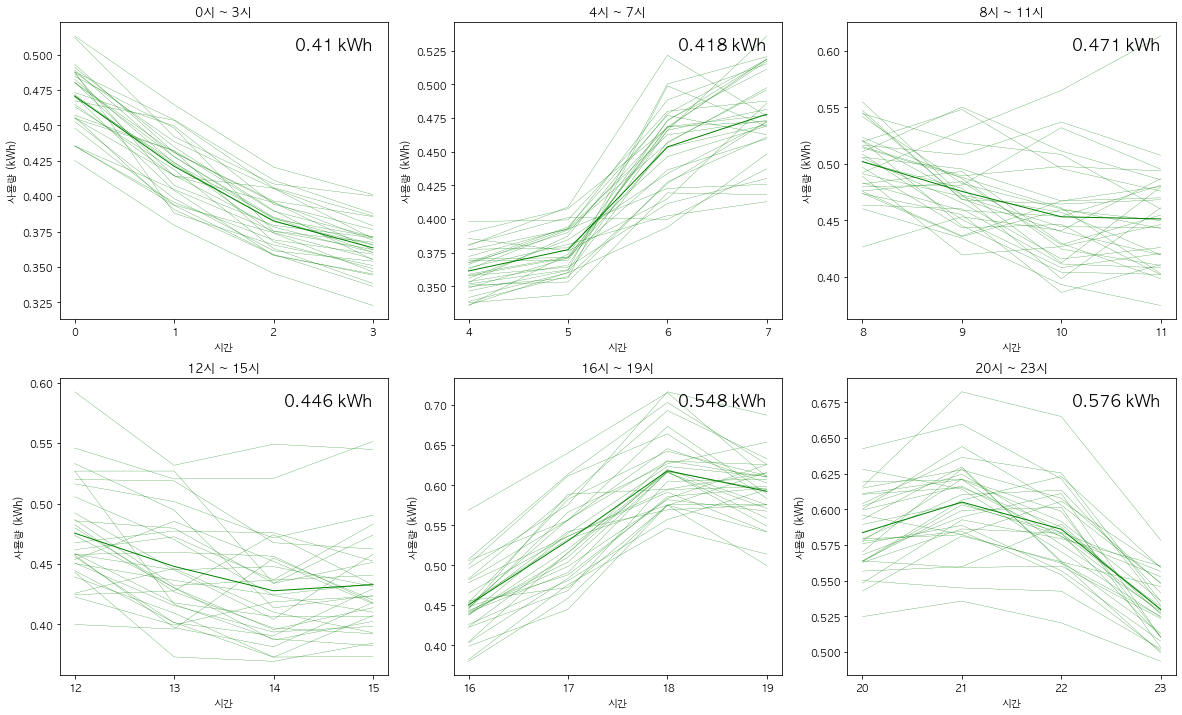

In [399]:
# 현재 자신이 속해 있는 기여도 그룹 현황
plt.figure(figsize=(20, 12))

for idx, group in enumerate(sv.clusters_[1][0]):
    mean_group = group.mean(axis=0)
    start_time, end_time = times[idx]
    ax = plt.subplot(2, 3, idx+1)
    
    ax.plot(range(start_time,end_time + 1),group.T, color='g', linewidth=0.25)
    ax.plot(range(start_time,end_time + 1),mean_group, color='g', linewidth=1)
    ax.set_title("{}시 ~ {}시".format(start_time, end_time))
    ax.text(0.95, 0.95, 
            "{} kWh".format(round(mean_group.mean() * 1000) / 1000), 
            fontsize=16,
            ha="right",
            va="top",
            transform=ax.transAxes)
    plt.xticks(range(start_time,end_time + 1))
    plt.xlabel("시간")
    plt.ylabel("사용량 (kWh)")

plt.show()

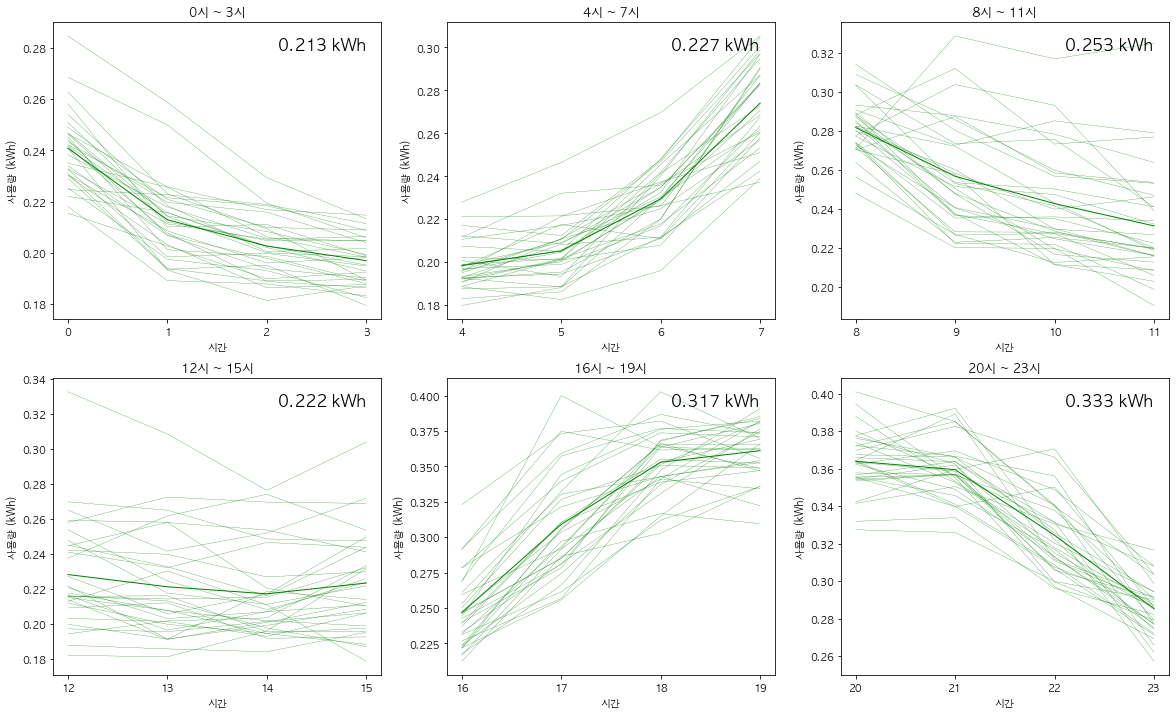

In [400]:
plt.figure(figsize=(20, 12))

for idx, group in enumerate(sv.clusters_[0][0]):
    mean_group = group.mean(axis=0)
    start_time, end_time = times[idx]
    ax = plt.subplot(2, 3, idx+1)
    
    ax.plot(range(start_time,end_time + 1),group.T, color='g', linewidth=0.25)
    ax.plot(range(start_time,end_time + 1),mean_group, color='g', linewidth=1)
    ax.set_title("{}시 ~ {}시".format(start_time, end_time))
    ax.text(0.95, 0.95, 
            "{} kWh".format(round(mean_group.mean() * 1000) / 1000), 
            fontsize=16,
            ha="right",
            va="top",
            transform=ax.transAxes)
    plt.xticks(range(start_time,end_time + 1))
    plt.xlabel("시간")
    plt.ylabel("사용량 (kWh)")

plt.show()

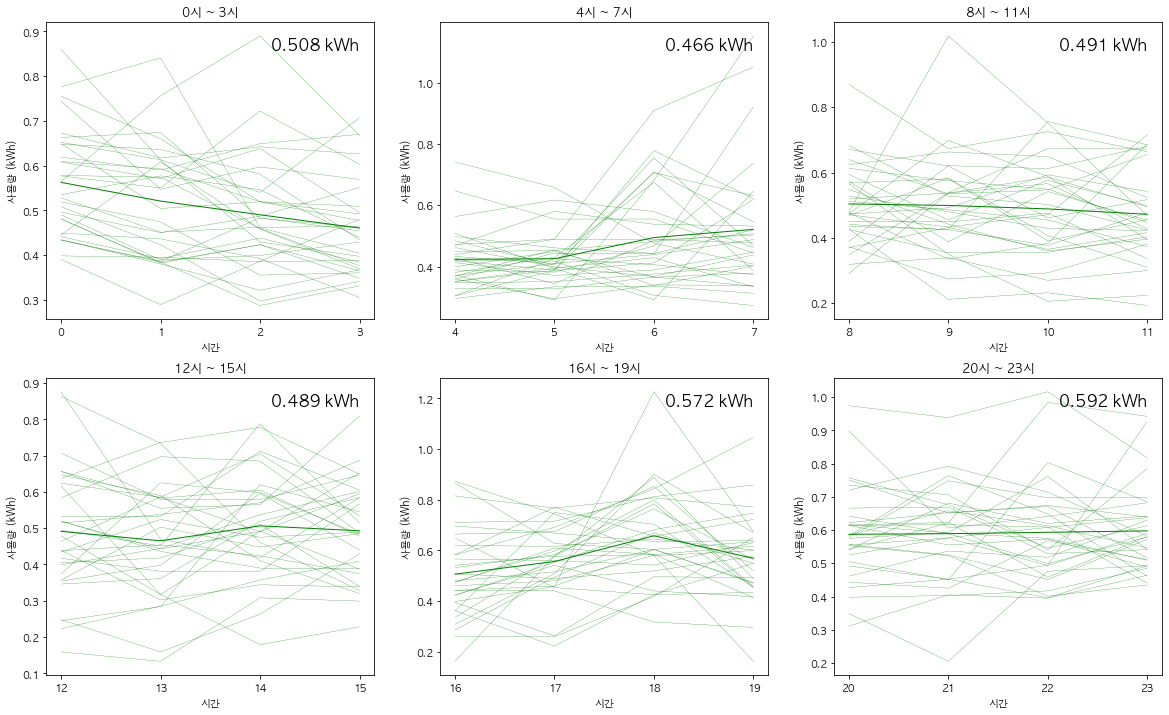

In [401]:
plt.figure(figsize=(20, 12))

for idx, group in enumerate(t_tg[0]):
    mean_group = group.mean(axis=0)
    start_time, end_time = times[idx]
    ax = plt.subplot(2, 3, idx+1)
    
    ax.plot(range(start_time,end_time + 1),group.T, color='g', linewidth=0.25)
    ax.plot(range(start_time,end_time + 1),mean_group, color='g', linewidth=1)
    ax.set_title("{}시 ~ {}시".format(start_time, end_time))
    ax.text(0.95, 0.95, 
            "{} kWh".format(round(mean_group.mean() * 1000) / 1000), 
            fontsize=16,
            ha="right",
            va="top",
            transform=ax.transAxes)
    plt.xticks(range(start_time,end_time + 1))
    plt.xlabel("시간")
    plt.ylabel("사용량 (kWh)")

plt.show()

In [493]:
def feedback(name):
    target_house = sv.group[sv.group['name'] == name]
    target_pattern = sv.datas[name].values
    print("절약 전 사용량",round(target_pattern.sum()))
    time_group, mean_time_group = sv.time_grouping(target_pattern, time_size)
    
    label = target_house['label'].values[0]
    if label == 0:
        return time_group, mean_time_group
    
    _now = (sv.clusters_[label][1].mean(axis=1) * 1000).astype(np.float).round() / 1000
    _prev = (sv.clusters_[label - 1][1].mean(axis=1) * 1000).astype(np.float).round() / 1000
    _target = (mean_time_group.mean(axis=1) * 1000).astype(np.float).round() / 1000
    
    now_saving_point = np.where(_target > _now)[0]
    prev_saving_point = np.where(_target > _prev)[0]
    prev_saving_point = prev_saving_point[~np.isin(prev_saving_point, now_saving_point)]
    saving_point = np.sort(np.append(now_saving_point, prev_saving_point))

    err = np.zeros(saving_point.size)
    err[now_saving_point] = _target[now_saving_point] - _now[now_saving_point]
    err[prev_saving_point] = _target[prev_saving_point] - _prev[prev_saving_point]

    sims = t_tg[0].copy()

    for idx, sim in enumerate(sims):
        sim -= err[idx]

        neg_err = sim[sim < 0]
        sim[sim < 0] = 0

        for neg in neg_err:
            chk = sim[sim > abs(neg)]
            if chk.size != 0:
                sim[sim > abs(neg)][0] += neg
    
    print("\n모든 사용량이 피드백 되었나요?", np.all(sims > 0))
    print("실천 최대 기대값",round(sims.sum()))
    
    return sims

In [494]:
sims = feedback("아파트1-103-1602")

절약 전 사용량 387

모든 사용량이 피드백 되었나요? True
실천 최대 기대값 356


In [495]:
sv.feedback()

In [518]:
sim_usage = [round(_.sum()) for _ in sv.simulations]
sv.new_group = sv.group.copy()
sv.new_group['usage (kWh)'] = sim_usage

print("아파트 현재 평균 사용량",sv.group['usage (kWh)'].mean())
print("아파트 실천 최대 기대 평균 사용량",sv.new_group['usage (kWh)'].mean())

아파트 현재 평균 사용량 288.0
아파트 실천 최대 기대 평균 사용량 239.72222222222223


In [550]:
APT = crs.utils.get_APT(sv.group[['name', 'usage (kWh)']], PUBLIC_PERCENTAGE)
public_kwh = APT - sv.group['usage (kWh)'].sum()

now_calc = crs.models.ManagementOffice(
        month=_month,
        households=sv.group[['name', 'usage (kWh)']],
        APT=APT,
        contract="단일계약"
    )

In [551]:
feedback_APT = sv.new_group['usage (kWh)'].sum() + public_kwh

feedback_calc = crs.models.ManagementOffice(
        month=_month,
        households=sv.new_group[['name', 'usage (kWh)']],
        APT=feedback_APT,
        contract="단일계약"
    )

In [557]:
print("APT 변화", APT, feedback_APT)
print("APT 평균사용량 변화", now_calc.apart.kwh, feedback_calc.apart.kwh)

print("아파트 전체 요금 변화", now_calc.bill, feedback_calc.bill)
print("공용부 요금 변화", now_calc.public_bill, feedback_calc.public_bill)


print("세대부 평균 사용량 변화", round(sv.group['usage (kWh)'].mean()), round(sv.new_group['usage (kWh)'].mean()))
print("세대부 전체 요금 변화", now_calc.bill - now_calc.public_bill,
                     feedback_calc.bill - feedback_calc.public_bill)

APT 변화 44434 39220
APT 평균사용량 변화 411 363
아파트 전체 요금 변화 6439540 4905450
공용부 요금 변화 2640560 2110670
세대부 평균 사용량 변화 288 240
세대부 전체 요금 변화 3798980 2794780
